In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import seaborn as sns
from nltk.parse.generate import generate
from nltk import CFG
from nltk.grammar import Nonterminal
from tqdm import tqdm

from eig.battleship import Parser

from battleship.grammar import BattleshipGrammar
from battleship.scoring import compute_score_parallel
from battleship.board import Board

# Configure seaborn
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.25)

# Battleship grammar

In [3]:
grammar = BattleshipGrammar(include_lambdas=False)

## Enumeration

In [ ]:
valid, invalid = grammar.generate(n=int(1e6), depth=5, start=Nonterminal('A'))
print('Valid programs:', len(valid))
print('Invalid programs:', len(invalid))

In [ ]:
# Pass `enforce_type=False` to `Parser.parse` to allow all toplevel types
program = Parser.parse("( and TRUE ( touch Red Blue ) )", enforce_type=False)

In [ ]:
program.to_dict()

## Sampling

In [28]:
n = int(1e5)
samples = [grammar.sample(min_depth=1, max_depth=16, allow_single_token=False) for _ in tqdm(range(n))]
# Remove None samples
samples = list(set(s for s in samples if s is not None))
print('Samples:', len(samples))

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:04<00:00, 21421.20it/s]

Samples: 24577


In [29]:
# sort samples by depth
samples_sorted = sorted(samples, key=lambda s: s[1])
samples_sorted[:10]

[('( color 5E )', 2),
 ('( > 6 2 )', 2),
 ('( < 1 2 )', 2),
 ('( colL 4B )', 2),
 ('( + 1 7 )', 2),
 ('( > 7 6 )', 2),
 ('( and TRUE TRUE )', 2),
 ('( colL 4C )', 2),
 ('( > 3 3 )', 2),
 ('( == 1 5 )', 2)]

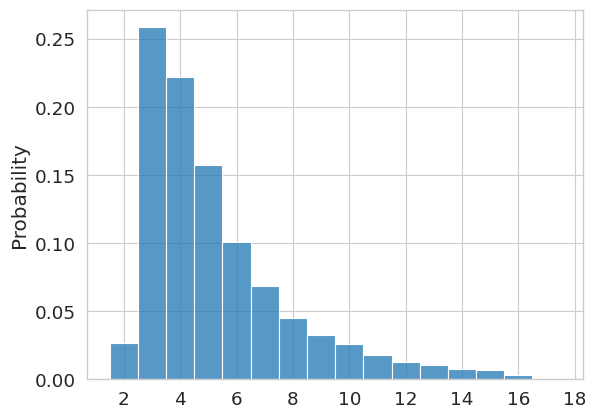

In [30]:
with sns.plotting_context("paper", font_scale=1.5):
    sns.histplot([d for (p, d) in samples], discrete=True, stat="probability")

## Scoring

In [ ]:
TRIAL_IDS = range(3, 19)

def evaluate_samples_all_trials(samples):
    # Deduplicate samples
    samples = list(set([x for x in samples if x is not None]))

    # Create dataframe to store scores
    df_scores = pd.DataFrame({"program": samples})
    df_scores["length"] = df_scores["program"].apply(lambda p: len(p))

    for trial_id in TRIAL_IDS:
        print(f"Evaluating trial {trial_id}")
        board = Board.from_trial_id(trial_id)
        scores = compute_score_parallel(programs=samples, board=board, processes=os.cpu_count() // 6)
        df_scores[f"score_{trial_id}"] = scores

    return df_scores

df_scores = evaluate_samples_all_trials(samples[:10000])

In [ ]:
board = Board.from_trial_id(4)
compute_score_parallel(programs=samples, board=board, processes=os.cpu_count() // 4)

In [ ]:
df_scores